# CNN model for classification of audio files with genre tags

deal with the unbalanced class labels with weighted labels

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import cv2
import json
import librosa
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import EarlyStopping

2024-04-10 06:53:35.016421: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 06:53:35.057422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 06:53:35.732405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Descriptive analysis of the MusicCaps audio files, metadata and tags

In [2]:
# Checking the audio files sent by Andrew 
# Checking the no. of audio files
audio_dir = '/home/mendu/Thesis/data/musiccaps/audio'
audio_list = os.listdir(audio_dir)
audio_list = [file_name.replace('.wav.mp3', '') for file_name in audio_list] # list of audio track names
print('Total number of audio files', len(audio_list))

Total number of audio files 5431


### Checking if there are tags for all the audio files

In [3]:
#Import paraquet files from "https://huggingface.co/datasets/seungheondoh/LP-MusicCaps-MC/tree/main/data"

test_tags = pd.read_parquet('/home/mendu/Thesis/data/musiccaps/test-00000-of-00001-7f4171b43c96395e.parquet', engine='pyarrow')
train_tags = pd.read_parquet('/home/mendu/Thesis/data/musiccaps/train-00000-of-00001-c4a67f61bdb1fbf4.parquet', engine='pyarrow')
meta_df = pd.concat([train_tags, test_tags]).reset_index(drop= True)

In [4]:
#Printing the head of the train tags dataframe
meta_df.head()

,fname,ytid,aspect_list,caption_ground_truth,caption_writing,caption_summary,caption_paraphrase,caption_attribute_prediction,pseudo_attribute,is_crawled,author_id,start_s,end_s,audioset_positive_labels,is_balanced_subset,is_audioset_eval
0,[-0SdAVK79lg]-[30-40],-0SdAVK79lg,"[guitar song, piano backing, simple percussion...",This song features an electric guitar as the m...,This gentle guitar song featuring a piano back...,This instrumental song features a relaxing mel...,The instrumental guitar song boasts a soothing...,This instrumental guitar song has a soft and r...,"[acoustic, folksy, chord progression]",True,0,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...",False,False
1,[-1LrH01Ei1w]-[30-40],-1LrH01Ei1w,"[rubab instrument, repetitive melody on differ...",This song features a rubber instrument being p...,An energizing instrumental track featuring the...,A fast tempo instrumental song featuring the r...,Experience the electrifying prowess of the tru...,This instrumental song features the rubab inst...,"[drum, bass guitar]",True,0,30,40,"/m/02p0sh1,/m/04rlf",False,False
2,[-4NLarMj4xU]-[30-40],-4NLarMj4xU,"[pop, tinny wide hi hats, mellow piano melody,...",The Pop song features a soft female vocal sing...,This pop ballad is filled with a mix of tinny ...,"The pop song features a mellow piano melody, s...",This pop ballad features a delicate piano melo...,This pop ballad features tinny wide hi hats an...,"[solo guitar, subtle strings, bright acoustic ...",True,4,30,40,"/m/04rlf,/t/dd00034",False,False
3,[-5f6hjZf9Yw]-[30-40],-5f6hjZf9Yw,"[folk music, rubab, male voice, slow tempo, em...",This folk song features a male voice singing t...,This emotional folk ballad features a poignant...,"A slow, emotional folk song featuring a male v...",This touching folk ballad featuring a male voc...,This heart-wrenching folk song features a mesm...,"[harmonica, melancholic lyrics, acoustic guitar]",True,0,30,40,"/m/02w4v,/m/04rlf",False,False
4,[-5xOcMJpTUk]-[70-80],-5xOcMJpTUk,"[guitarist, male talking, twang sounds, medioc...",A male guitarist plays the guitar and speaks a...,This energetic song demo features a passionate...,This energetic and passionate song features a ...,This home music video showcases a male guitari...,This home music video features a male guitaris...,"[electric guitar, rock genre, guitar riff, gui...",True,1,70,80,"/m/018vs,/m/0342h,/m/042v_gx,/m/04rlf,/m/04szw...",False,False


In [5]:
#List of all the audio names in the meta_df
meta_audio_names = meta_df['fname'].tolist()

In [6]:
#Printing the shape and column names of the tags files
print('The length of the tags are', meta_df.shape)
print(meta_df.columns)

The length of the tags are (5521, 16)
Index(['fname', 'ytid', 'aspect_list', 'caption_ground_truth',
       'caption_writing', 'caption_summary', 'caption_paraphrase',
       'caption_attribute_prediction', 'pseudo_attribute', 'is_crawled',
       'author_id', 'start_s', 'end_s', 'audioset_positive_labels',
       'is_balanced_subset', 'is_audioset_eval'],
      dtype='object')


In [7]:
#Checking if all the filename in the audio_df for which we have an audio file for exists in the meta_df and hence has tags
if set(audio_list).issubset(set(meta_audio_names)):
    print('The audio files all have a tag row from the paraquet files')

The audio files all have a tag row from the paraquet files


## Looking into the tags

In [8]:
#Creating a list of all the unique tags in the data

#the aspect_list col as a list
tags_list = meta_df['aspect_list'].to_list()

# Flatten the tags_list
flat_list = [item for sublist in tags_list for item in sublist]

# Remove duplicates
tags_list_flat = list(set(flat_list))

print(tags_list_flat[:5])

['country singer', 'horror soundtrack', 'electric guitar strumming', 'funky piano', 'mandolin solo melody']


In [9]:
#Number of unique tags
len(tags_list_flat)

13219

In [10]:
# Count occurrences of each tag
counter = Counter(flat_list)

# Convert counter to DataFrame
tags_counter = pd.DataFrame(counter.items(), columns=['Tags', 'Count'])
tags_counter = tags_counter.sort_values('Count', ascending= False).reset_index(drop = True)

tags_counter

,Tags,Count
0,low quality,1220
1,instrumental,908
2,emotional,636
3,noisy,628
4,passionate,610
...,...,...
13214,ticking clock percussions,1
13215,various sound effects,1
13216,the sringa,1
13217,indonesian pop,1


In [11]:
#Hand select the genrefrom the top 300 tags
genre_tags = ['instrumental', 'instrumental music', 'rock', 'pop', 'electronic music', 'dance music', 'classical', 'traditional','orchestra',
 'jazz', 'classical music', 'r&b', 'folk', 'electro', 'edm', 'folk music', 'hard rock', 'hip hop', 'hip-hop', 'metal', 'pop song',
 'heavy metal', 'urban', 'country music', 'electronic dance music', 'techno', 'rap', 'trance', 'folk song', 'pop music', 'soul', 'rock music',
 'soft rock', 'synth pop', 'electronic', 'country', 'western classical music', 'alternative rock']

In [12]:
#Creating a dictionary with the similar genres that can be merged
same_tags = {'instrumental': ['instrumental', 'instrumental music'], 'rock': ['rock', 'hard rock', 'rock music', 'soft rock', 'alternative rock'],
             'pop': ['pop', 'pop song', 'pop music', 'synth pop', 'dance music'], 'electronic': ['electronic music', 'electro', 'edm', 'electronic dance music',
             'techno', 'trance', 'electronic'], 'classical': ['classical', 'classical music', 'western classical music', 'orchestra'], 'folk':
            ['folk', 'folk music', 'folk song', 'traditional'], 'hip hop': ['hip hop', 'hip-hop', 'urban', 'rap'], 'metal': ['metal', 'heavy metal'], 'country':
            ['country music', 'country'], 'r&b': ['r&b', 'soul']}

Eventually the genres we would be having are:
- instrumental
- rock
- pop
- electronic
- classical
- folk
- hip hop
- metal
- country
- r&b
- jazz


as of now 11 genres

In [13]:
tags_counter_sub = tags_counter[tags_counter.Tags.isin(genre_tags)].reset_index(drop = True)
print('The total number of rows with the subset of tags is', tags_counter_sub.Count.sum())

tags_counter_sub.head()

The total number of rows with the subset of tags is 3515


,Tags,Count
0,instrumental,908
1,instrumental music,260
2,rock,207
3,pop,199
4,electronic music,134


## Subsetting the data for the top genres

In [14]:
# Copying meta_df and only keeping the audio name and tags list
filtered_df = meta_df.copy()
filtered_df = filtered_df[['fname', 'aspect_list']] 

# Filter rows based on genre tags and keep only elements that are in genre_tags
filtered_df['aspect_list'] = filtered_df['aspect_list'].apply(lambda x: [tag for tag in x if tag in genre_tags])

# Remove rows where aspect_list is empty
filtered_df = filtered_df[filtered_df['aspect_list'].apply(len) > 0].reset_index(drop=True)

In [15]:
'''
Replace tags in aspect_list with corresponding keys from same_tags dictionary
- iterates over the rows: row consists of column name and value, you can access the values for column aspect_list with row['aspect_list']
- iterates over each element in the aspect_list list
- iterates over same_tags dictionary: Here it checks if the the tag from the previous for loop is present in the value. If it exists
the key to the new_tags list, else the tag variable is appended
- if that are more than one tags and one of it is instrumental drop instrumental
'''

for idx, row in filtered_df.iterrows(): #iterates over the rows
    new_tags = []
    for tag in row['aspect_list']: #iterates over each element in the aspect_list list
        for key, values in same_tags.items(): #iterates over same_tags dictionary
            if tag in values:
                new_tags.append(key)
                break
        else:
            new_tags.append(tag)
    if len(new_tags) > 1 and 'instrumental' in new_tags: #if that are more than one tags and one of it is instrumental drop instrumental
        new_tags.remove('instrumental')
    filtered_df.at[idx, 'aspect_list'] = list(set(new_tags))

In [16]:
filtered_df.shape

(2563, 2)

In [17]:
filtered_df[filtered_df['aspect_list'].apply(len) > 1]

,fname,aspect_list
5,[-6pcgdLfb_A]-[110-120],"[r&b, hip hop]"
14,[-YATTKBtmRA]-[190-200],"[hip hop, electronic]"
21,[-wVWjl9Kq6U]-[240-250],"[rock, r&b]"
28,[0ADP-O_V3vA]-[30-40],"[pop, folk]"
38,[0RDz0rLakwc]-[30-40],"[hip hop, electronic]"
...,...,...
2473,[u6tgeRXOxnU]-[30-40],"[pop, hip hop, electronic]"
2474,[u9n4R78UBtA]-[30-40],"[pop, electronic]"
2485,[u_TfWvyYY0Y]-[30-40],"[metal, rock]"
2524,[xb07gLlmkL8]-[30-40],"[pop, rock]"


In [18]:
#Getting rid of all those rows that have two tags for simplicity

# Remove rows where aspect_list contains two elements
filtered_df = filtered_df[filtered_df['aspect_list'].apply(len) <= 1].reset_index(drop=True)

# Convert aspect_list into a string
filtered_df['aspect_list'] = filtered_df['aspect_list'].apply(lambda x: x[0])

filtered_df

,fname,aspect_list
0,[-0SdAVK79lg]-[30-40],instrumental
1,[-1LrH01Ei1w]-[30-40],instrumental
2,[-4NLarMj4xU]-[30-40],pop
3,[-5f6hjZf9Yw]-[30-40],folk
4,[-6QGvxvaTkI]-[280-290],folk
...,...,...
2360,[zjsWFvUkh7M]-[30-40],rock
2361,[zrrM6Qg2Dwg]-[30-40],instrumental
2362,[zwfo7wnXdjs]-[30-40],folk
2363,[zx_vcwOsDO4]-[50-60],instrumental


In [19]:
#the aspect_list col as a list
filtered_tags_list = filtered_df['aspect_list'].to_list()

# Flatten the tags_list
# flat_list_ = [item for sublist in filtered_tags_list for item in sublist]

# Count occurrences of each tag
counter_ = Counter(filtered_tags_list)

# Convert counter to DataFrame
filtered_tags_counter = pd.DataFrame(counter_.items(), columns=['Tags', 'Count'])
filtered_tags_counter = filtered_tags_counter.sort_values('Count', ascending= False).reset_index(drop = True)

filtered_tags_counter

,Tags,Count
0,instrumental,745
1,pop,301
2,rock,257
3,classical,250
4,electronic,244
5,folk,201
6,hip hop,123
7,jazz,72
8,country,61
9,r&b,59


In [20]:
filtered_tags_counter['Tags'][:11].to_list()

['instrumental',
 'pop',
 'rock',
 'classical',
 'electronic',
 'folk',
 'hip hop',
 'jazz',
 'country',
 'r&b',
 'metal']

Only keeping the first 11 genres

In [21]:
#list of top twelve genres
# top_genres = filtered_tags_counter['Tags'][:11].to_list()

#filtering df to only keep
# filtered_df = filtered_df[filtered_df['aspect_list'].isin(top_genres)].reset_index(drop = True)

#Only keep those rows for which the mel-spec exists
mel_list = os.listdir('/home/mendu/Thesis/data/musiccaps/mel-specs')
mel_list = [fname.replace('.wav.npy', '') for fname in mel_list]

filtered_df = filtered_df[filtered_df['fname'].isin(mel_list)].reset_index(drop = True)

#Removing [pYXx0xXZiXk]-[14-24] and [-SWaCArvQug]-[21-31] because they are not of the right shape
filtered_df = filtered_df.drop(filtered_df[filtered_df['fname'] == '[pYXx0xXZiXk]-[14-24]'].index)
filtered_df = filtered_df.drop(filtered_df[filtered_df['fname'] == '[-SWaCArvQug]-[21-31]'].index)

filtered_df

,fname,aspect_list
0,[-0SdAVK79lg]-[30-40],instrumental
1,[-1LrH01Ei1w]-[30-40],instrumental
2,[-4NLarMj4xU]-[30-40],pop
3,[-5f6hjZf9Yw]-[30-40],folk
4,[-6QGvxvaTkI]-[280-290],folk
...,...,...
2316,[zjsWFvUkh7M]-[30-40],rock
2317,[zrrM6Qg2Dwg]-[30-40],instrumental
2318,[zwfo7wnXdjs]-[30-40],folk
2319,[zx_vcwOsDO4]-[50-60],instrumental


In [26]:
class_counts = filtered_df['aspect_list'].value_counts()
max_samples = class_counts.max()

# Resample the data to balance the classes
resampled_data = []
for class_name, count in class_counts.items():
    # Calculate the number of samples to add to balance the class distribution
    num_samples_to_add = max_samples - count
    
    # Resample the minority class (with replacement)
    minority_class_samples = filtered_df[filtered_df['aspect_list'] == class_name].sample(n=num_samples_to_add, replace=True, random_state=42)
    
    # Append the resampled minority class samples to the resampled data list
    resampled_data.append(minority_class_samples)

# Concatenate the resampled data to create the balanced dataset
balanced_df = pd.concat([filtered_df] + resampled_data, ignore_index=True)

# Verify the class distribution in the balanced dataset
print(balanced_df['aspect_list'].value_counts())

aspect_list
instrumental    730
pop             730
folk            730
electronic      730
rock            730
country         730
hip hop         730
jazz            730
classical       730
metal           730
r&b             730
Name: count, dtype: int64


In [28]:
balanced_df.to_csv('/home/mendu/Thesis/data/musiccaps/balanced_meta_df.csv')

In [79]:
# filtered_df.to_csv('/home/mendu/Thesis/data/musiccaps/filtered_meta_df.csv')

## Generating mel-spectrograms

In [24]:
# Function to convert mp3 files to mel-spectrograms
def mp3_to_melspectrogram(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mp3"):
            # Load the audio file
            audio_path = os.path.join(input_folder, filename)
            y, sr = librosa.load(audio_path)

            # Compute the mel-spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # Convert to decibel scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Save the mel-spectrogram as .npy file
            output_path = os.path.join(output_folder, filename.replace('.mp3', '.npy'))
            np.save(output_path, mel_spectrogram_db)

            # print(f"Mel-spectrogram saved: {output_path}")

In [25]:
#generating mel-specs
input_folder = '/home/mendu/Thesis/data/musiccaps/audio'
output_folder = '/home/mendu/Thesis/data/musiccaps/mel-specs'
# mp3_to_melspectrogram(input_folder, output_folder)

# Training the model

In [22]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [23]:
len(filtered_df.fname.to_list())

2319

In [92]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/musiccaps/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = filtered_df.fname.to_list()

data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename) + '.wav.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  
  # Check to ensure the image has the minimum required dimensions
  if img.shape[0] >= 128 and img.shape[1] >= 431:
    img = img[:128, :431]
    data.append(add_gauss_noise(img))
  else:
    print(f"Error with file: {filename_npy}. Expected minimum shape of (128, 431) but got {img.shape}.")
    # Handle the error properly, either skip this image or pad/crop it accordingly

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


[-0SdAVK79lg]-[30-40]
[-1LrH01Ei1w]-[30-40]
[-4NLarMj4xU]-[30-40]
[-5f6hjZf9Yw]-[30-40]
[-6QGvxvaTkI]-[280-290]
[-Dtir74TiUM]-[40-50]
[-FlvaZQOr2I]-[90-100]
[-JVWfFPBl84]-[330-340]
[-M-6VinyMiY]-[30-40]
[-O9mnfC61Ac]-[0-10]


In [94]:
#normalize data
data = data.astype('float32')/255.0

In [95]:
data.shape

(2319, 128, 431)

In [96]:
filtered_df

,fname,aspect_list
0,[-0SdAVK79lg]-[30-40],instrumental
1,[-1LrH01Ei1w]-[30-40],instrumental
2,[-4NLarMj4xU]-[30-40],pop
3,[-5f6hjZf9Yw]-[30-40],folk
4,[-6QGvxvaTkI]-[280-290],folk
...,...,...
2316,[zjsWFvUkh7M]-[30-40],rock
2317,[zrrM6Qg2Dwg]-[30-40],instrumental
2318,[zwfo7wnXdjs]-[30-40],folk
2319,[zx_vcwOsDO4]-[50-60],instrumental


In [38]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 431, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(filtered_df['aspect_list']), test_size=0.1, random_state=42)

# Compute class weights manually for one-hot encoded labels
class_totals = y_train.sum(axis=0)
total_samples = y_train.shape[0]
class_weights = total_samples / (len(class_totals) * class_totals)

# Convert class weights to a dictionary for easier use
class_weight_dict = dict(enumerate(class_weights))

In [39]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [40]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

12

In [49]:
#l2 regularisation
ltwo_reg = 0.01

# Initialize the model
model = Sequential()

#Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=(128, 431, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 429, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 126, 429, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 212, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 61, 212, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 104, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 104, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 28, 104, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 93184)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,927,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,022,956 (45.86 MB)

 Trainable params: 12,022,252 (45.86 MB)

 Non-trainable params: 704 (2.75 KB)

In [46]:
data.shape

(2245, 128, 431, 1)

In [55]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    # class_weight=class_weight_dict,
    callbacks=[early_stopper]
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.3745 - loss: 4.3018 - val_accuracy: 0.3200 - val_loss: 4.6703
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.4675 - loss: 3.8509 - val_accuracy: 0.3200 - val_loss: 5.6353
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step - accuracy: 0.5250 - loss: 3.6661 - val_accuracy: 0.3200 - val_loss: 4.5839
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.5359 - loss: 3.6773 - val_accuracy: 0.0356 - val_loss: 5.2734
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.5623 - loss: 4.0599 - val_accuracy: 0.3200 - val_loss: 4.9922
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.5982 - loss: 3.8187 - val_accuracy: 0.3067 - val_loss: 5.7756
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.6114 - loss: 3.8849 - val_accuracy: 0.3333 - val_loss: 5.6559
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step - accuracy: 0.6347 - loss: 3.9996 - 

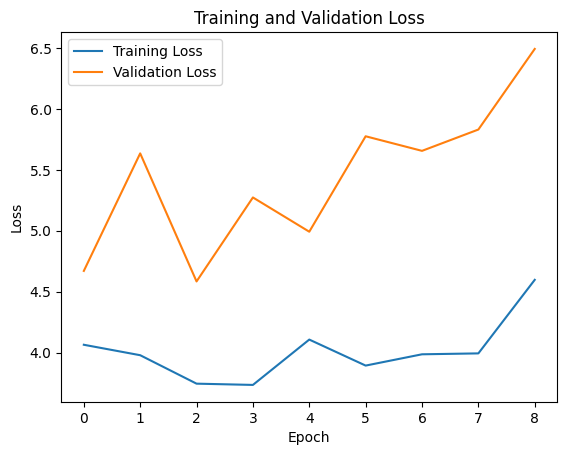

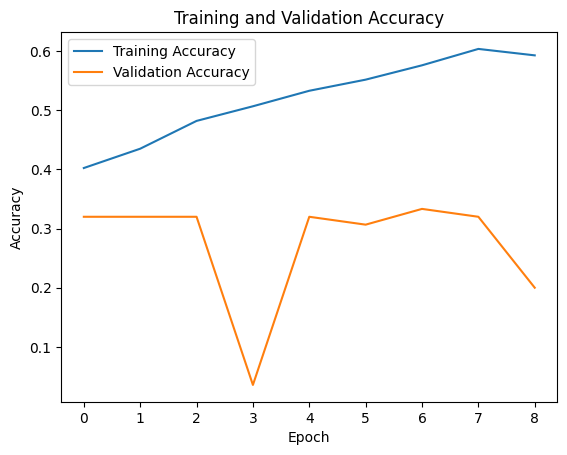

In [56]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
class_labels = ['classical', 'country', 'dance music', 'electronic', 'folk', 'hip hop', 
               'instrumental', 'jazz', 'orchestra', 'pop', 'r&b', 'rock']

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Creating a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [58]:
comparison_table

,Predicted,Ground Truth
0,hip hop,hip hop
1,hip hop,country
2,hip hop,dance music
3,hip hop,electronic
4,hip hop,rock
...,...,...
220,hip hop,hip hop
221,hip hop,pop
222,hip hop,rock
223,hip hop,hip hop


In [59]:
comparison_table['Ground Truth'].value_counts()

Ground Truth
hip hop         72
dance music     30
pop             28
classical       28
rock            24
electronic      14
folk            13
instrumental     4
r&b              4
country          3
orchestra        3
jazz             2
Name: count, dtype: int64

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/colab_data/cnn_4k_l20.002_30ep.keras')

In [ ]:
# Load the model
loaded_model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l20.004_30ep.keras')

In [40]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3287 - loss: 2.6297
Validation Loss: 2.602569341659546, Validation Accuracy: 0.3539822995662689


In [ ]:
# # Train model
# history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# # history = model.fit(
# #     augmented_data_gen,
# #     steps_per_epoch=len(X_train) // batch_size,
# #     epochs=10,  # Number of epochs to train for
# #     validation_data=(X_val, y_val)
# # )

In [ ]:
# # Train for 10 more epochs
# history_20 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10)

# # history_20 = model.fit(
# #     augmented_data_gen,
# #     steps_per_epoch=len(X_train) // batch_size,
# #     epochs=20,
# #     validation_data=(X_val, y_val),
# #     initial_epoch=10
# # )

In [ ]:
# # Train for 10 more epochs
# history_30 = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), initial_epoch=20)

# # history_30 = model.fit(
# #     augmented_data_gen,
# #     steps_per_epoch=len(X_train) // batch_size,
# #     epochs=30,
# #     validation_data=(X_val, y_val),
# #     initial_epoch=20
# # )

In [ ]:
# history_40 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), initial_epoch=30)

In [ ]:
# history_50 = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), initial_epoch=40)

In [ ]:
# history_60 = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val), initial_epoch=50)

In [ ]:
# history_70 = model.fit(X_train, y_train, batch_size=32, epochs=70, validation_data=(X_val, y_val), initial_epoch=60)

In [ ]:
# history_80 = model.fit(X_train, y_train, batch_size=32, epochs=80, validation_data=(X_val, y_val), initial_epoch=70)

In [ ]:
# history_90 = model.fit(X_train, y_train, batch_size=32, epochs=90, validation_data=(X_val, y_val), initial_epoch=80)

In [ ]:
# history_100 = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), initial_epoch=90)

In [ ]:
# # Concatenate the old and new history
# full_history = {}
# for key in history.history.keys():
#     # full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key] + history_40.history[key] + history_50.history[key] + history_60.history[key] + history_70.history[key] + history_80.history[key] + history_90.history[key] + history_100.history[key]
#     full_history[key] = history.history[key] + history_20.history[key]

In [ ]:
# # Plot training loss
# plt.plot(full_history['loss'], label='Training Loss')
# plt.plot(full_history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot training accuracy
# plt.plot(full_history['accuracy'], label='Training Accuracy')
# plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


In [ ]:
# #checking the no. of spectrograms and their size
# mel_dir = '/home/mendu/Thesis/data/musiccaps/audio'
# mel_list = os.listdir(mel_dir)
# # mel_npy = np.load(f'{mel_dir}/{mel_list[25]}') #loading the 26th file to check the size
# print('Count of npy files: ', len(mel_list))
# # print('Size of image: ', mel_npy.shape)

In [ ]:
# # Filter rows based on genre tags
# filtered_df = meta_df[meta_df['aspect_list'].apply(lambda x: any(tag in x for tag in genre_tags))]

# print(filtered_df)

In [ ]:
# import matplotlib.pyplot as plt

# # Define the data
# epochs = list(range(1, 31))  # Assuming 30 epochs
# train_loss = [3.1024, 2.3673, 2.2814, 2.2056, 2.1723, 2.1417, 2.1223, 2.1314, 2.1052, 2.1025, 2.0961, 2.0911, 2.0806, 2.1007, 2.0791, 2.0792, 2.0732, 2.0681, 2.0666, 2.0602, 2.0665, 2.0690, 2.0689, 2.0640, 2.0514, 2.0593, 2.0629, 2.0557, 2.0695, 2.0646]
# val_loss = [2.3848, 2.2317, 2.1796, 2.1162, 2.0936, 2.0726, 2.0700, 2.0816, 2.1067, 2.0504, 2.0372, 2.0261, 2.0269, 2.0264, 2.0271, 2.0361, 2.0115, 2.0132, 1.9988, 2.0171, 2.0062, 2.0093, 2.0190, 2.0003, 1.9912, 2.0077, 2.0126, 1.9861, 2.0034, 2.0032]
# train_accuracy = [0.2343, 0.2407, 0.2444, 0.2415, 0.2464, 0.2577, 0.2556, 0.2569, 0.2593, 0.2782, 0.2621, 0.2754, 0.2625, 0.2681, 0.2839, 0.2762, 0.2730, 0.2815, 0.2806, 0.2786, 0.2774, 0.2750, 0.2810, 0.2742, 0.2843, 0.2738, 0.2742, 0.2766, 0.2815, 0.2802]
# val_accuracy = [0.2560, 0.2609, 0.2754, 0.2593, 0.2625, 0.2609, 0.2705, 0.2802, 0.2609, 0.2271, 0.2866, 0.2754, 0.2882, 0.2818, 0.2915, 0.2866, 0.2915, 0.2995, 0.3043, 0.3060, 0.2947, 0.2995, 0.2866, 0.3027, 0.3124, 0.3043, 0.3060, 0.3140, 0.2963, 0.2995]

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# # Extend the data
# epochs.extend(list(range(31, 41)))
# train_loss.extend([2.0558, 2.0505, 2.0560, 2.0447, 2.0454, 2.0497, 2.0410, 2.0472, 2.0453, 2.0478])
# val_loss.extend([1.9879, 1.9850, 1.9891, 1.9840, 2.0198, 1.9872, 1.9954, 1.9865, 1.9993, 1.9872])
# train_accuracy.extend([0.2891, 0.2823, 0.2847, 0.2653, 0.2891, 0.2750, 0.2730, 0.2851, 0.2835, 0.2871])
# val_accuracy.extend([0.3156, 0.3060, 0.3124, 0.3060, 0.3043, 0.3011, 0.2963, 0.3092, 0.3124, 0.3060])

# # Plot the data
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy plot
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''

In [ ]:
'''creates a custom data generator for data augmentation and adds gaussian noise to 20% of the training data and mixup to all'''

# # Define a Mixup function
# def mixup(X, y, alpha=0.2):
#     if np.random.rand() < 0.2:  # Apply Mixup to 20% of the images
#         batch_size = X.shape[0]
#         l = np.random.beta(alpha, alpha, batch_size)
#         X_l = l.reshape(batch_size, 1, 1, 1)
#         y_l = l.reshape(batch_size, 1)

#         X_mixup = X * X_l + X[::-1] * (1 - X_l)
#         y_mixup = y * y_l + y[::-1] * (1 - y_l)
#         return X_mixup, y_mixup
#     else:
#         return X, y

# # Create an augmenter for Gaussian noise
# gaussian_noise = iaa.AdditiveGaussianNoise(scale=0.01 * 255)

# # Define the custom generator
# def custom_generator(datagen, gaussian_noise, X_train, Y_train, batch_size):
#     generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
#     while True:
#         X_batch, y_batch = next(generator)

#         # Decide whether to apply Gaussian noise
#         if np.random.rand() < 0.2:  # Apply Gaussian noise to 20% of the images
#             X_batch = gaussian_noise.augment_images(X_batch)

#         # Apply Mixup
#         X_batch, y_batch = mixup(X_batch, y_batch)
#         yield X_batch, y_batch

# # Usage example
# batch_size = 32
# alpha = 0.2  # Adjust Mixup's alpha value if needed
# augmented_data_gen = custom_generator(datagen, gaussian_noise, X_train, y_train, batch_size)